In [2]:
# !pip install tables

In [3]:
import pandas as pd
import glob
import os
from pathlib import Path
import h5py
from joblib import Parallel, delayed

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
replacement_map = {
    '├Ê': 'É',
    '├â': 'Ã',
    '├ü': 'Á',
    '├ç': 'Ç',
    '├ì': 'Í',
    '├Ò': 'é',
    '├│': 'ó',
    '├¡': 'í',
    '├ú': 'ã',
    '├í': 'á',
    '├º': 'ç',
    '├ô': 'Ó',
    '├õ': 'Ô',
    '├Ü': 'Ú',
    '├è': 'Ê',
    '├é': 'Â',
    '├┤': 'ô',
    '├║': 'ú',
    '├ò': 'õ',
    '├¬': 'ê',
    '├ó': 'â',
    '├╡': 'õ',
    '├Õ': 'Ú'
}

def fix_encoding(text, replacement_map):
    """
    Corrects encoding issues in a given text by replacing incorrectly encoded characters
    with their correct counterparts using a provided replacement map.

    Parameters:
        text (str): The input string that may contain incorrectly encoded characters.
        replacement_map (dict): A dictionary where keys are the incorrectly encoded
                                characters and values are the correct characters to
                                replace them with.

    Returns:
        str: The corrected text with all instances of incorrectly encoded characters
             replaced by their correct counterparts.

    Example:
        text = "This is a t├¬st with s├│me encoding probl├¡ms."
        corrected_text = fix_encoding(text, replacement_map)
        print(corrected_text)
        # Output: "This is a têst with sóme encoding problems."

    How It Works:
        1. Iterates over each key-value pair in the `replacement_map`.
        2. Replaces all occurrences of the incorrect character (key) in the input `text`
           with the correct character (value).
        3. Returns the corrected text after all replacements are made.

    Notes:
        - The function is case-sensitive, so ensure the keys in `replacement_map` match
          the exact incorrect characters in the text.
        - The `replacement_map` should be tailored to the specific encoding issues
          present in the text.
    """
    for incorrect, correct in replacement_map.items():
        text = text.replace(incorrect, correct)
    return text

In [7]:
# Function to read a single HDF5 file
def read_hdf_file(file_path, key_table):
    """
    Reads a single HDF5 file and returns the data.

    Parameters:
    file_path (str): The path to the HDF5 file.

    Returns:
    DataFrame: The data contained in the HDF5 file.
    """
    return pd.read_hdf(file_path, key=key_table)

In [8]:
def convert_state_abbreviations_to_names(df, abbreviation_column):
    # Dictionary mapping state abbreviations to their full names
    state_mapping = {
        'AC': 'ACRE',
        'AL': 'ALAGOAS',
        'AP': 'AMAPÁ',
        'AM': 'AMAZONAS',
        'BA': 'BAHIA',
        'CE': 'CEARÁ',
        'DF': 'DISTRITO FEDERAL',
        'ES': 'ESPÍRITO SANTO',
        'GO': 'GOIÁS',
        'MA': 'MARANHÃO',
        'MT': 'MATO GROSSO',
        'MS': 'MATO GROSSO DO SUL',
        'MG': 'MINAS GERAIS',
        'PA': 'PARÁ',
        'PB': 'PARAÍBA',
        'PR': 'PARANÁ',
        'PE': 'PERNAMBUCO',
        'PI': 'PIAUÍ',
        'RJ': 'RIO DE JANEIRO',
        'RN': 'RIO GRANDE DO NORTE',
        'RS': 'RIO GRANDE DO SUL',
        'RO': 'RONDÔNIA',
        'RR': 'RORAIMA',
        'SC': 'SANTA CATARINA',
        'SP': 'SÃO PAULO',
        'SE': 'SERGIPE',
        'TO': 'TOCANTINS'
    }
    reverse_state_mapping = {v: k for k, v in state_mapping.items()}

    # Create a new column with the full names of the states
    df[abbreviation_column] = df[abbreviation_column].str.upper().replace(state_mapping)

    # Create a new column with the full names of the states
    df['state_abbreviation'] = df[abbreviation_column].str.upper().replace(reverse_state_mapping)

    return df

# BRAZIL

In [9]:
# brazilolder_path = Path("./1 - Organized data gauge/BRAZIL/")
brazil_folder_path = "/content/drive/MyDrive/QualiBRain/Scripts e Dados/1 - Organized data gauge/"
brazil_h5_files = glob.glob(os.path.join(brazil_folder_path, "*.h5"))
print("quantity of files:", len(brazil_h5_files), "\nexample:", brazil_h5_files[0])

quantity of files: 4 
example: /content/drive/MyDrive/QualiBRain/Scripts e Dados/1 - Organized data gauge/TELEMETRIA_DAILY_2021_2023.h5


In [10]:
table_key = 'table_info'

# Use parallel processing to read all files
brazil_list_info = Parallel(n_jobs=-1)(delayed(read_hdf_file)(filename, table_key) for filename in brazil_h5_files)

# Concatenate and remove duplicates
df_brazil_gauge_info = pd.concat(brazil_list_info).drop_duplicates(ignore_index=True)
del brazil_list_info

df_brazil_gauge_info['city'] = df_brazil_gauge_info['city'].apply(lambda x: x.upper())
df_brazil_gauge_info['state'] = df_brazil_gauge_info['state'].apply(lambda x: str(x).upper())
df_brazil_gauge_info = convert_state_abbreviations_to_names(df_brazil_gauge_info, 'state')


# df_brazil_gauge_info = df_brazil_gauge_info[['gauge_code',	'state',	'city',	'name_station',	'lat',	'long',	'responsible', 'source']]
df_brazil_gauge_info

,gauge_code,state,city,name_station,lat,long,responsible,source,state_abbreviation
0,12500000,ACRE,CRUZEIRO DO SUL,CRUZEIRO DO SUL,-7.633300,-72.660300,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
1,12510500,ACRE,TARAUACÁ,PONTE DO RIO LIBERDADE,-7.799400,-72.021100,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
2,12557000,ACRE,JORDÃO,JORDÃO,-9.188300,-71.952500,00380 - SEMA-AC - Secretaria de Meio Ambiente ...,TELEMETRIA,AC
3,12590000,ACRE,TARAUACÁ,PONTE DE TARAUACÁ,-8.151900,-70.745600,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
4,12640000,ACRE,FEIJÓ,SERINGAL SANTA HELENA,-8.685800,-70.551100,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
...,...,...,...,...,...,...,...,...,...
18883,261500301A,PERNAMBUCO,TAQUARITINGA DO NORTE,Taquaritinga do Norte [CAIC] - APAC,-7.898380,-36.050430,CEMADEN,CEMADEN,PE
18884,261520102A,PERNAMBUCO,TERRA NOVA,Terra Nova [Escola Francisco Hugo] - APAC,-8.224680,-39.376600,CEMADEN,CEMADEN,PE
18885,261590401A,PERNAMBUCO,TUPARETAMA,Tuparetama [Compesa] - APAC,-7.602240,-37.309420,CEMADEN,CEMADEN,PE
18886,261610001A,PERNAMBUCO,VERDEJANTE,VERDEJANTE - APAC,-7.930167,-38.968306,CEMADEN,CEMADEN,PE


In [11]:
table_key = 'table_data'

# Use parallel processing to read all files
brazil_list_data = Parallel(n_jobs=-1)(delayed(read_hdf_file)(filename, table_key) for filename in brazil_h5_files)

# Concatenate and remove duplicates
# df_brazil_gauge_data = pd.concat(brazil_list_data).drop_duplicates(ignore_index=True)
df_brazil_gauge_data = pd.concat(brazil_list_data)
del brazil_list_data

# df_brazil_gauge_data = df_brazil_gauge_data[['gauge_code',	'datetime',	'rain_mm']]
df_brazil_gauge_data['gauge_code'] = df_brazil_gauge_data['gauge_code'].astype(str)
df_brazil_gauge_data

,gauge_code,datetime,rain_mm
0,02042051,2021-07-31,0.00
1,02042051,2021-08-01,1.00
2,02042051,2021-08-02,0.00
3,02042051,2021-08-03,0.60
4,02042051,2021-08-04,1.00
...,...,...,...
3597090,CEMADEN_12,2023-02-24,0.42
3597091,CEMADEN_12,2023-02-25,0.00
3597092,CEMADEN_12,2023-02-26,0.00
3597093,CEMADEN_12,2023-02-27,1.78


In [12]:
df_brazil_gauge_data.dtypes

,0
gauge_code,object
datetime,datetime64[ns]
rain_mm,float64


In [13]:
# df_brazil_gauge_data.to_hdf('./1 - Organized data gauge/BRAZIL_GAUGE_DATA_2021_2024.h5', key='table_data', mode='w', complevel=9, complib='zlib', encoding='utf-8')
df_brazil_gauge_data.to_hdf('BRAZIL_DAILY_1961_2024.h5', key='table_data', mode='w', complevel=9, complib='zlib', encoding='utf-8')
del df_brazil_gauge_data

In [14]:
# df_brazil_gauge_info.to_hdf('./1 - Organized data gauge/BRAZIL_GAUGE_DATA_2021_2024.h5', key='table_info', mode='r+', complevel=9, complib='zlib', encoding='utf-8')
df_brazil_gauge_info.to_hdf('BRAZIL_DAILY_1961_2024.h5', key='table_info', mode='r+', complevel=9, complib='zlib', encoding='utf-8')
del df_brazil_gauge_info

In [15]:
df = pd.read_hdf('BRAZIL_DAILY_1961_2024.h5', key='table_info')
df

,gauge_code,state,city,name_station,lat,long,responsible,source,state_abbreviation
0,12500000,ACRE,CRUZEIRO DO SUL,CRUZEIRO DO SUL,-7.633300,-72.660300,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
1,12510500,ACRE,TARAUACÁ,PONTE DO RIO LIBERDADE,-7.799400,-72.021100,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
2,12557000,ACRE,JORDÃO,JORDÃO,-9.188300,-71.952500,00380 - SEMA-AC - Secretaria de Meio Ambiente ...,TELEMETRIA,AC
3,12590000,ACRE,TARAUACÁ,PONTE DE TARAUACÁ,-8.151900,-70.745600,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
4,12640000,ACRE,FEIJÓ,SERINGAL SANTA HELENA,-8.685800,-70.551100,00001 - ANA - Agência Nacional de Águas,TELEMETRIA,AC
...,...,...,...,...,...,...,...,...,...
18883,261500301A,PERNAMBUCO,TAQUARITINGA DO NORTE,Taquaritinga do Norte [CAIC] - APAC,-7.898380,-36.050430,CEMADEN,CEMADEN,PE
18884,261520102A,PERNAMBUCO,TERRA NOVA,Terra Nova [Escola Francisco Hugo] - APAC,-8.224680,-39.376600,CEMADEN,CEMADEN,PE
18885,261590401A,PERNAMBUCO,TUPARETAMA,Tuparetama [Compesa] - APAC,-7.602240,-37.309420,CEMADEN,CEMADEN,PE
18886,261610001A,PERNAMBUCO,VERDEJANTE,VERDEJANTE - APAC,-7.930167,-38.968306,CEMADEN,CEMADEN,PE


In [ ]:
# df = pd.read_hdf(r'BRAZIL_DAILY_1961_2024.h5', key='table_data').sort_values(by='datetime')
# df

,gauge_code,datetime,rain_mm
0,00047000,1961-01-01,0.0
68389117,02145007,1961-01-01,13.0
24192766,00738029,1961-01-01,0.0
90398299,02347134,1961-01-01,0.0
102114124,02551004,1961-01-01,0.0
...,...,...,...
915541,40974900,2024-12-31,50.4
915224,40963000,2024-12-31,16.0
2718677,83674000,2024-12-31,3.2
1369059,292740809G,2024-12-31,0.0


# data check

In [7]:
df = pd.read_hdf(r".\1 - Organized data gauge\BRAZIL\BRAZIL_DAILY_1961_2024.h5", key='table_data')
df

,gauge_code,datetime,rain_mm
0,00047000,1961-01-01,0.0
1,00047000,1961-01-02,0.0
2,00047000,1961-01-03,0.0
3,00047000,1961-01-04,0.0
4,00047000,1961-01-05,0.0
...,...,...,...
1076753,S717,2021-12-27,0.0
1076754,S717,2021-12-28,0.0
1076755,S717,2021-12-29,0.0
1076756,S717,2021-12-30,0.0


In [9]:
df_test = df[df['datetime'] == "2013-02-08"]
df_test.sort_values(['rain_mm'], inplace=True)
df_test

C:\Users\linde\AppData\Local\Temp\ipykernel_21396\3563927511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.sort_values(['rain_mm'], inplace=True)


,gauge_code,datetime,rain_mm
41643255,01246009,2013-02-08,0.0
41398587,01244019,2013-02-08,0.0
41406022,01244020,2013-02-08,0.0
41412597,01244021,2013-02-08,0.0
41423264,01244023,2013-02-08,0.0
...,...,...,...
91489372,02349016,2013-02-08,120.0
54387568,01756002,2013-02-08,128.0
98301114,02452011,2013-02-08,143.7
66486240,02055001,2013-02-08,145.0


In [11]:
df_station = df[
    (df['gauge_code'] == '00651001')
    & (df['datetime'] >= '2013-02-07')] #00651001 00655004
df_station

,gauge_code,datetime,rain_mm
21128500,00651001,2013-02-07,4.6
21128501,00651001,2013-02-08,536.0
21128502,00651001,2013-02-09,2.6
21128503,00651001,2013-02-10,0.0
21128504,00651001,2013-02-11,1.3
...,...,...,...
21131380,00651001,2020-12-27,0.0
21131381,00651001,2020-12-28,2.9
21131382,00651001,2020-12-29,0.0
21131383,00651001,2020-12-30,20.2


In [21]:
df_station['year'] = df_station['datetime'].dt.year
df_station

C:\Users\linde\AppData\Local\Temp\ipykernel_25720\862369651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['year'] = df_station['datetime'].dt.year


,gauge_code,datetime,rain_mm,year
21196682,00655004,1999-08-03,0.0,1999
21196683,00655004,1999-08-04,0.0,1999
21196684,00655004,1999-08-05,0.0,1999
21196685,00655004,1999-08-06,0.0,1999
21196686,00655004,1999-08-07,0.0,1999
...,...,...,...,...
21204499,00655004,2020-12-27,0.0,2020
21204500,00655004,2020-12-28,5.6,2020
21204501,00655004,2020-12-29,33.4,2020
21204502,00655004,2020-12-30,6.2,2020


In [22]:
df_grouped = df_station.groupby(['gauge_code', 'year'])['rain_mm'].sum().reset_index()
df_grouped

,gauge_code,year,rain_mm
0,00655004,1999,777.10
1,00655004,2000,2215.90
2,00655004,2001,2487.20
3,00655004,2002,2023.30
4,00655004,2003,1489.50
5,00655004,2004,1945.10
6,00655004,2005,1014.70
7,00655004,2006,925.00
8,00655004,2007,2525.70
9,00655004,2008,2133.20


<Axes: xlabel='datetime'>

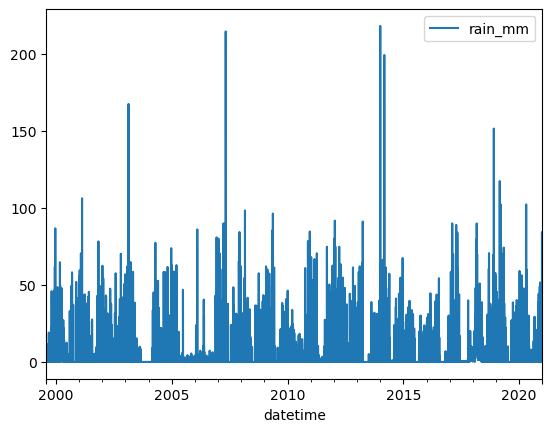

In [23]:
df_station[['datetime', 'rain_mm']].plot(x='datetime', y='rain_mm')
